In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Specifications

In [2]:
save = False 

# Load Claims Data

In [3]:
# Load the combined Processed_Claims.csv file
processed_claims_file = "../../../no_percentile_filter/final_filtered_claims.csv"
filtered_claims_df = pd.read_csv(processed_claims_file)

# Ensure that 'countyCode' is properly formatted as a 5-character string
filtered_claims_df['countyCode'] = filtered_claims_df['countyCode'].astype(int).astype(str)
filtered_claims_df['countyCode'] = filtered_claims_df['countyCode'].apply(lambda x: str(x).zfill(5))

/tmp/ipykernel_12452/1470826358.py:3: DtypeWarning: Columns (8,33,36,39,43,52,53,62) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_claims_df = pd.read_csv(processed_claims_file)


In [4]:
# Aggregate the means
aggregated_df = filtered_claims_df.groupby('countyCode').agg({
    'returnPeriod_PRISM': 'mean',
    'PRISM_mon_percentile': 'mean',
    'PRISM_mon_precipitation': 'mean',
    'ERA5_precipitation_30d_sum': 'mean',
    'ERA5_precipitation_30d_sum_percentile_modeled': 'mean',
    'returnPeriod_ERA5_30d': 'mean',
    'MSWEP_precipitation_30d_sum':'mean',
    'MSWEP_precipitation_30d_sum_percentile_modeled': 'mean',
    'returnPeriod_MSWEP_30d': 'mean',
}).reset_index()

# Load the county shapefile
county_shapefile_path = '../../../../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../../../../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Merge the aggregated data with the county shapefile
gdf_counties = gdf_counties.merge(aggregated_df, left_on='GEOID', right_on='countyCode', how='left')

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

In [5]:
# Define two custom color palettes: 
# Left column: same red-blue color palette
colors_left = [
    '#e29578',  # Dark red for low values
    '#ffddd2',  # Light red
    '#edf6f9',  # Gray for values near 0
    '#83c5be',  # Light blue
    '#006d77'   # Dark blue for high values
]
cmap_left = mcolors.LinearSegmentedColormap.from_list('custom_cmap_left', colors_left, N=256)

# Right column: different red-blue color palette
colors_right = [
    '#d73027',  # Dark red
    '#fc8d59',  # Lighter red
    '#fee08b',  # Yellow near zero
    '#91bfdb',  # Light blue for mid-range
    '#4575b4'   # Dark blue for high values
]
cmap_right = mcolors.LinearSegmentedColormap.from_list('custom_cmap_right', colors_right, N=256)

# Define a color for counties with no data
no_data_color = '#a0a0a0'  # Light gray for no data

In [6]:
# Function to label medians
def label_medians(ax, data):
    for i, dataset in enumerate(data):
        median = dataset.median()
        ax.annotate(
            f'{median:.1f}', 
            xy=(i, median), 
            xycoords='data', 
            xytext=(0, 5), 
            textcoords='offset points', 
            ha='center', 
            fontsize=8, 
            color='black'
        )

In [7]:
# Define the data and labels
data_labels = ['Monthly', 'Weekly', '3-Day', '1-Day']
columns_msw = [
    'returnPeriod_MSWEP_30d', 
    'returnPeriod_MSWEP_7d', 
    'returnPeriod_MSWEP_3d', 
    'returnPeriod_MSWEP_1d'
]
columns_era = [
    'returnPeriod_ERA5_30d', 
    'returnPeriod_ERA5_7d', 
    'returnPeriod_ERA5_3d', 
    'returnPeriod_ERA5_1d'
]

# Prepare data for MSWEP and ERA5
data_msw = [filtered_claims_df[col] for col in columns_msw]
data_era = [filtered_claims_df[col] for col in columns_era]

In [8]:
# Load the combined Processed_Claims.csv file
processed_buyouts_file = "../../../no_percentile_filter/final_filtered_buyouts.csv"
filtered_buyouts_df = pd.read_csv(processed_buyouts_file)

# Ensure that 'countyCode' is properly formatted as a 5-character string
filtered_buyouts_df['countyCode'] = filtered_buyouts_df['countyCode'].astype(int).astype(str)
filtered_buyouts_df['countyCode'] = filtered_buyouts_df['countyCode'].apply(lambda x: str(x).zfill(5))

/tmp/ipykernel_12452/3175859260.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_buyouts_df = pd.read_csv(processed_buyouts_file)


In [9]:
# Prepare data for MSWEP and ERA5
data_msw_buyouts = [filtered_buyouts_df[col] for col in columns_msw]
data_era_buyouts = [filtered_buyouts_df[col] for col in columns_era]

In [10]:
# Read the two CSV files
owners_df = pd.read_csv("../../../no_percentile_filter/final_filtered_aid_owners.csv")
renters_df = pd.read_csv("../../../no_percentile_filter/final_filtered_aid_renters.csv")

# Concatenate the dataframes
filtered_aid_df = pd.concat([owners_df, renters_df], ignore_index=True)
filtered_aid_df = filtered_aid_df.rename(columns={"fullFIPS": "countyCode"})

# Replace NaNs with 0 and ensure all values are non-negative integers
filtered_aid_df['approvedForFemaAssistance'] = pd.to_numeric(
    filtered_aid_df['approvedForFemaAssistance'], errors='coerce'
).fillna(0).clip(lower=0).astype(int)

# Ensure the column is an integer (it should represent the number of repetitions)
filtered_aid_df = filtered_aid_df.loc[filtered_aid_df.index.repeat(filtered_aid_df['approvedForFemaAssistance'])]

# Reset the index (optional, for a cleaner index after repetition)
filtered_aid_df = filtered_aid_df.reset_index(drop=True)

# Ensure that 'countyCode' is properly formatted as a 5-character string
filtered_aid_df['countyCode'] = filtered_aid_df['countyCode'].astype(int).astype(str)
filtered_aid_df['countyCode'] = filtered_aid_df['countyCode'].apply(lambda x: str(x).zfill(5))

In [11]:
# Prepare data for MSWEP and ERA5
data_msw_aid = [filtered_aid_df[col] for col in columns_msw]
data_era_aid = [filtered_aid_df[col] for col in columns_era]

In [12]:
# (Optional but recommended) Make fonts Illustrator-friendly & compress embedded rasters
mpl.rcParams.update({
    "pdf.fonttype": 42,      # TrueType (editable text in AI)
    "ps.fonttype": 42,
    "pdf.compression": 9,    # max compression for embedded rasters
    "path.simplify": True,   # optional: slightly simplify line paths
    "path.simplify_threshold": 0.3,
})

# Helper: rasterize all collections on a given axes (e.g., polygon fills),
# but keep linework/vector text as vector
def rasterize_heavy_vectors(ax):
    for coll in ax.collections:
        coll.set_rasterized(True)
        coll.set_zorder(0)
    for patch in ax.patches:              # bars, box rectangles, violins
        patch.set_rasterized(True)
        patch.set_zorder(0)
    for art in getattr(ax, "artists", []):  # seaborn box patches live here
        if hasattr(art, "set_rasterized"):
            art.set_rasterized(True)
            art.set_zorder(0)
    for line in ax.lines:                 # whiskers, caps, medians, hlines
        line.set_rasterized(True)
        line.set_zorder(0)

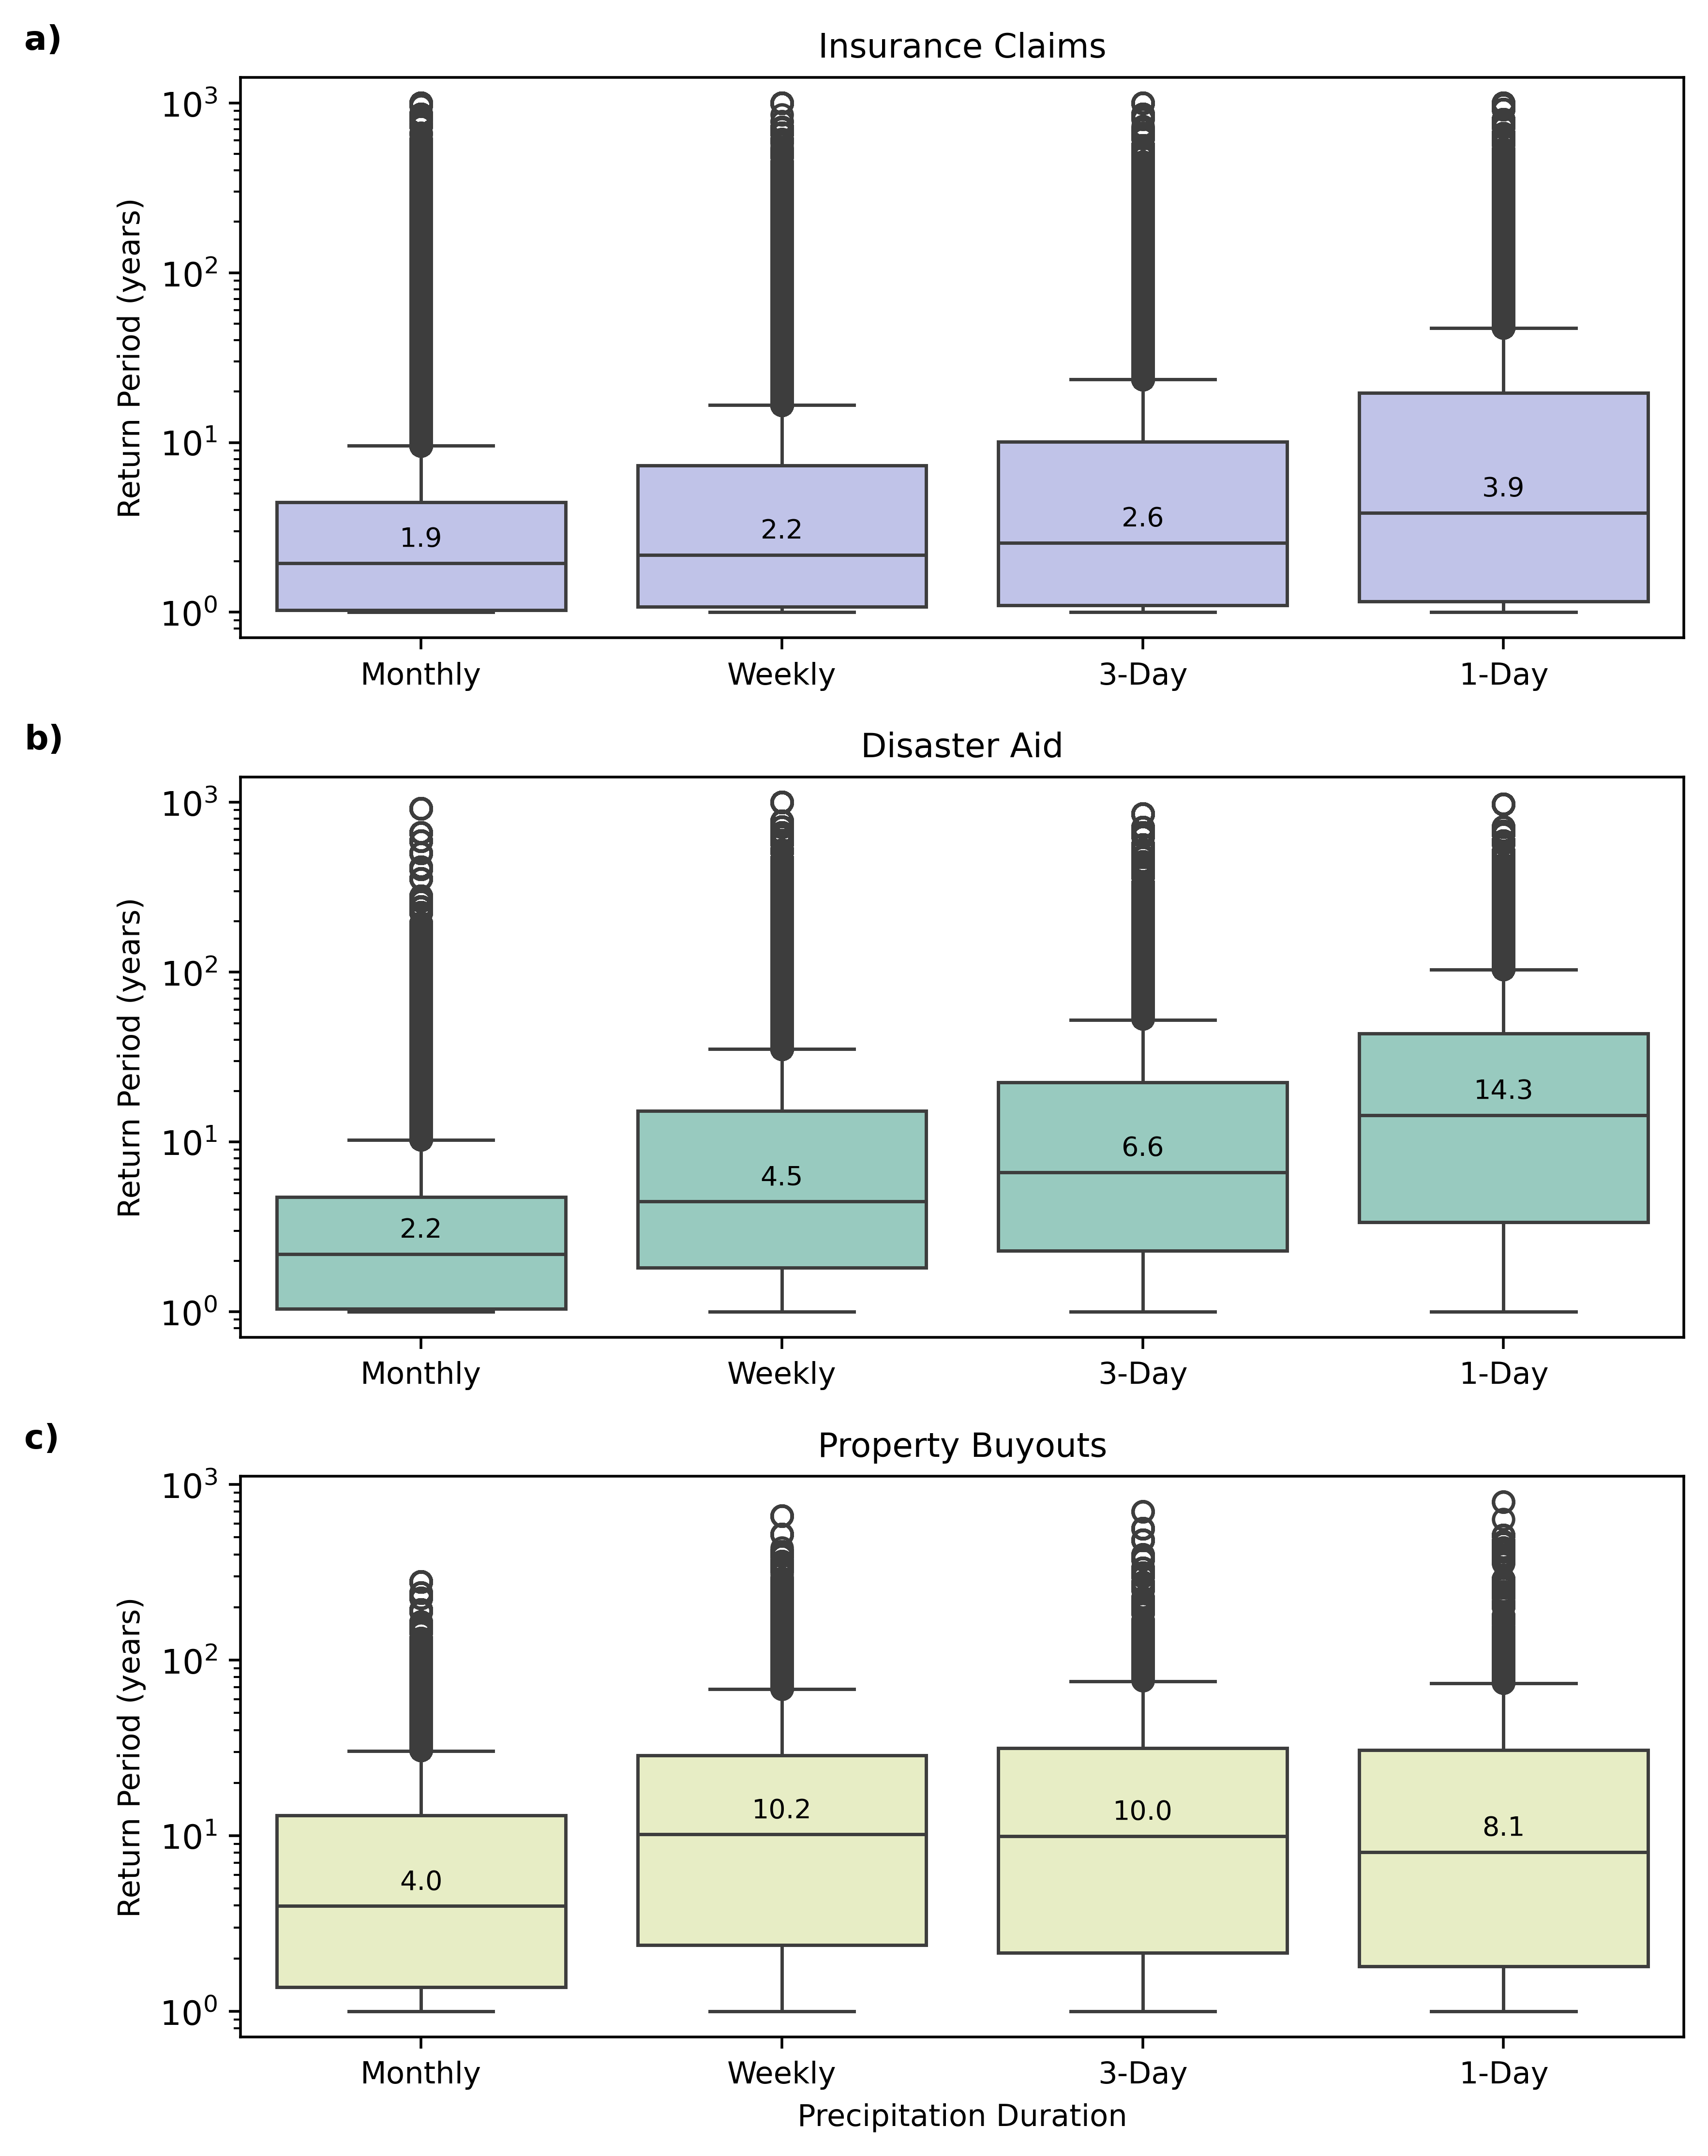

In [13]:
# Set figure size with a width constraint of 7.09 inches (~180mm)
fig_width = 7.09  # inches
fig_height = 9    # Adjust height for three rows
fig, axes = plt.subplots(3, 1, figsize=(fig_width, fig_height), dpi=500)

# Titles for the subplots
titles = ['Insurance Claims', 'Disaster Aid', 'Property Buyouts']

# Plotting the boxplots
sns.boxplot(data=data_msw, ax=axes[0], showfliers=True, color="#babeee") #whis=[5, 95]
sns.boxplot(data=data_msw_aid, ax=axes[1], showfliers=True, color="#90d2c3")
sns.boxplot(data=data_msw_buyouts, ax=axes[2], showfliers=True, color="#ecf4be")
rasterize_heavy_vectors(axes[0])
rasterize_heavy_vectors(axes[1])
rasterize_heavy_vectors(axes[2])

# Add median labels
label_medians(axes[0], data_msw)
label_medians(axes[1], data_msw_aid)
label_medians(axes[2], data_msw_buyouts)

# Set subplot titles
for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks(range(len(data_labels)))
    ax.set_xticklabels(data_labels, fontsize=9)
    ax.set_yscale("log")
    ax.set_ylabel('Return Period (years)', fontsize=9)
    #ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add a common xlabel for all plots
axes[2].set_xlabel('Precipitation Duration', fontsize=9)

# Add subplot labels
axes[0].text(-0.15, 1.05, 'a)', transform=axes[0].transAxes, size=10, weight='bold')
axes[1].text(-0.15, 1.05, 'b)', transform=axes[1].transAxes, size=10, weight='bold')
axes[2].text(-0.15, 1.05, 'c)', transform=axes[2].transAxes, size=10, weight='bold')

# Adjust layout and save the plot if needed
plt.tight_layout()
if save:
    plt.savefig('../../../Plots/F2.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

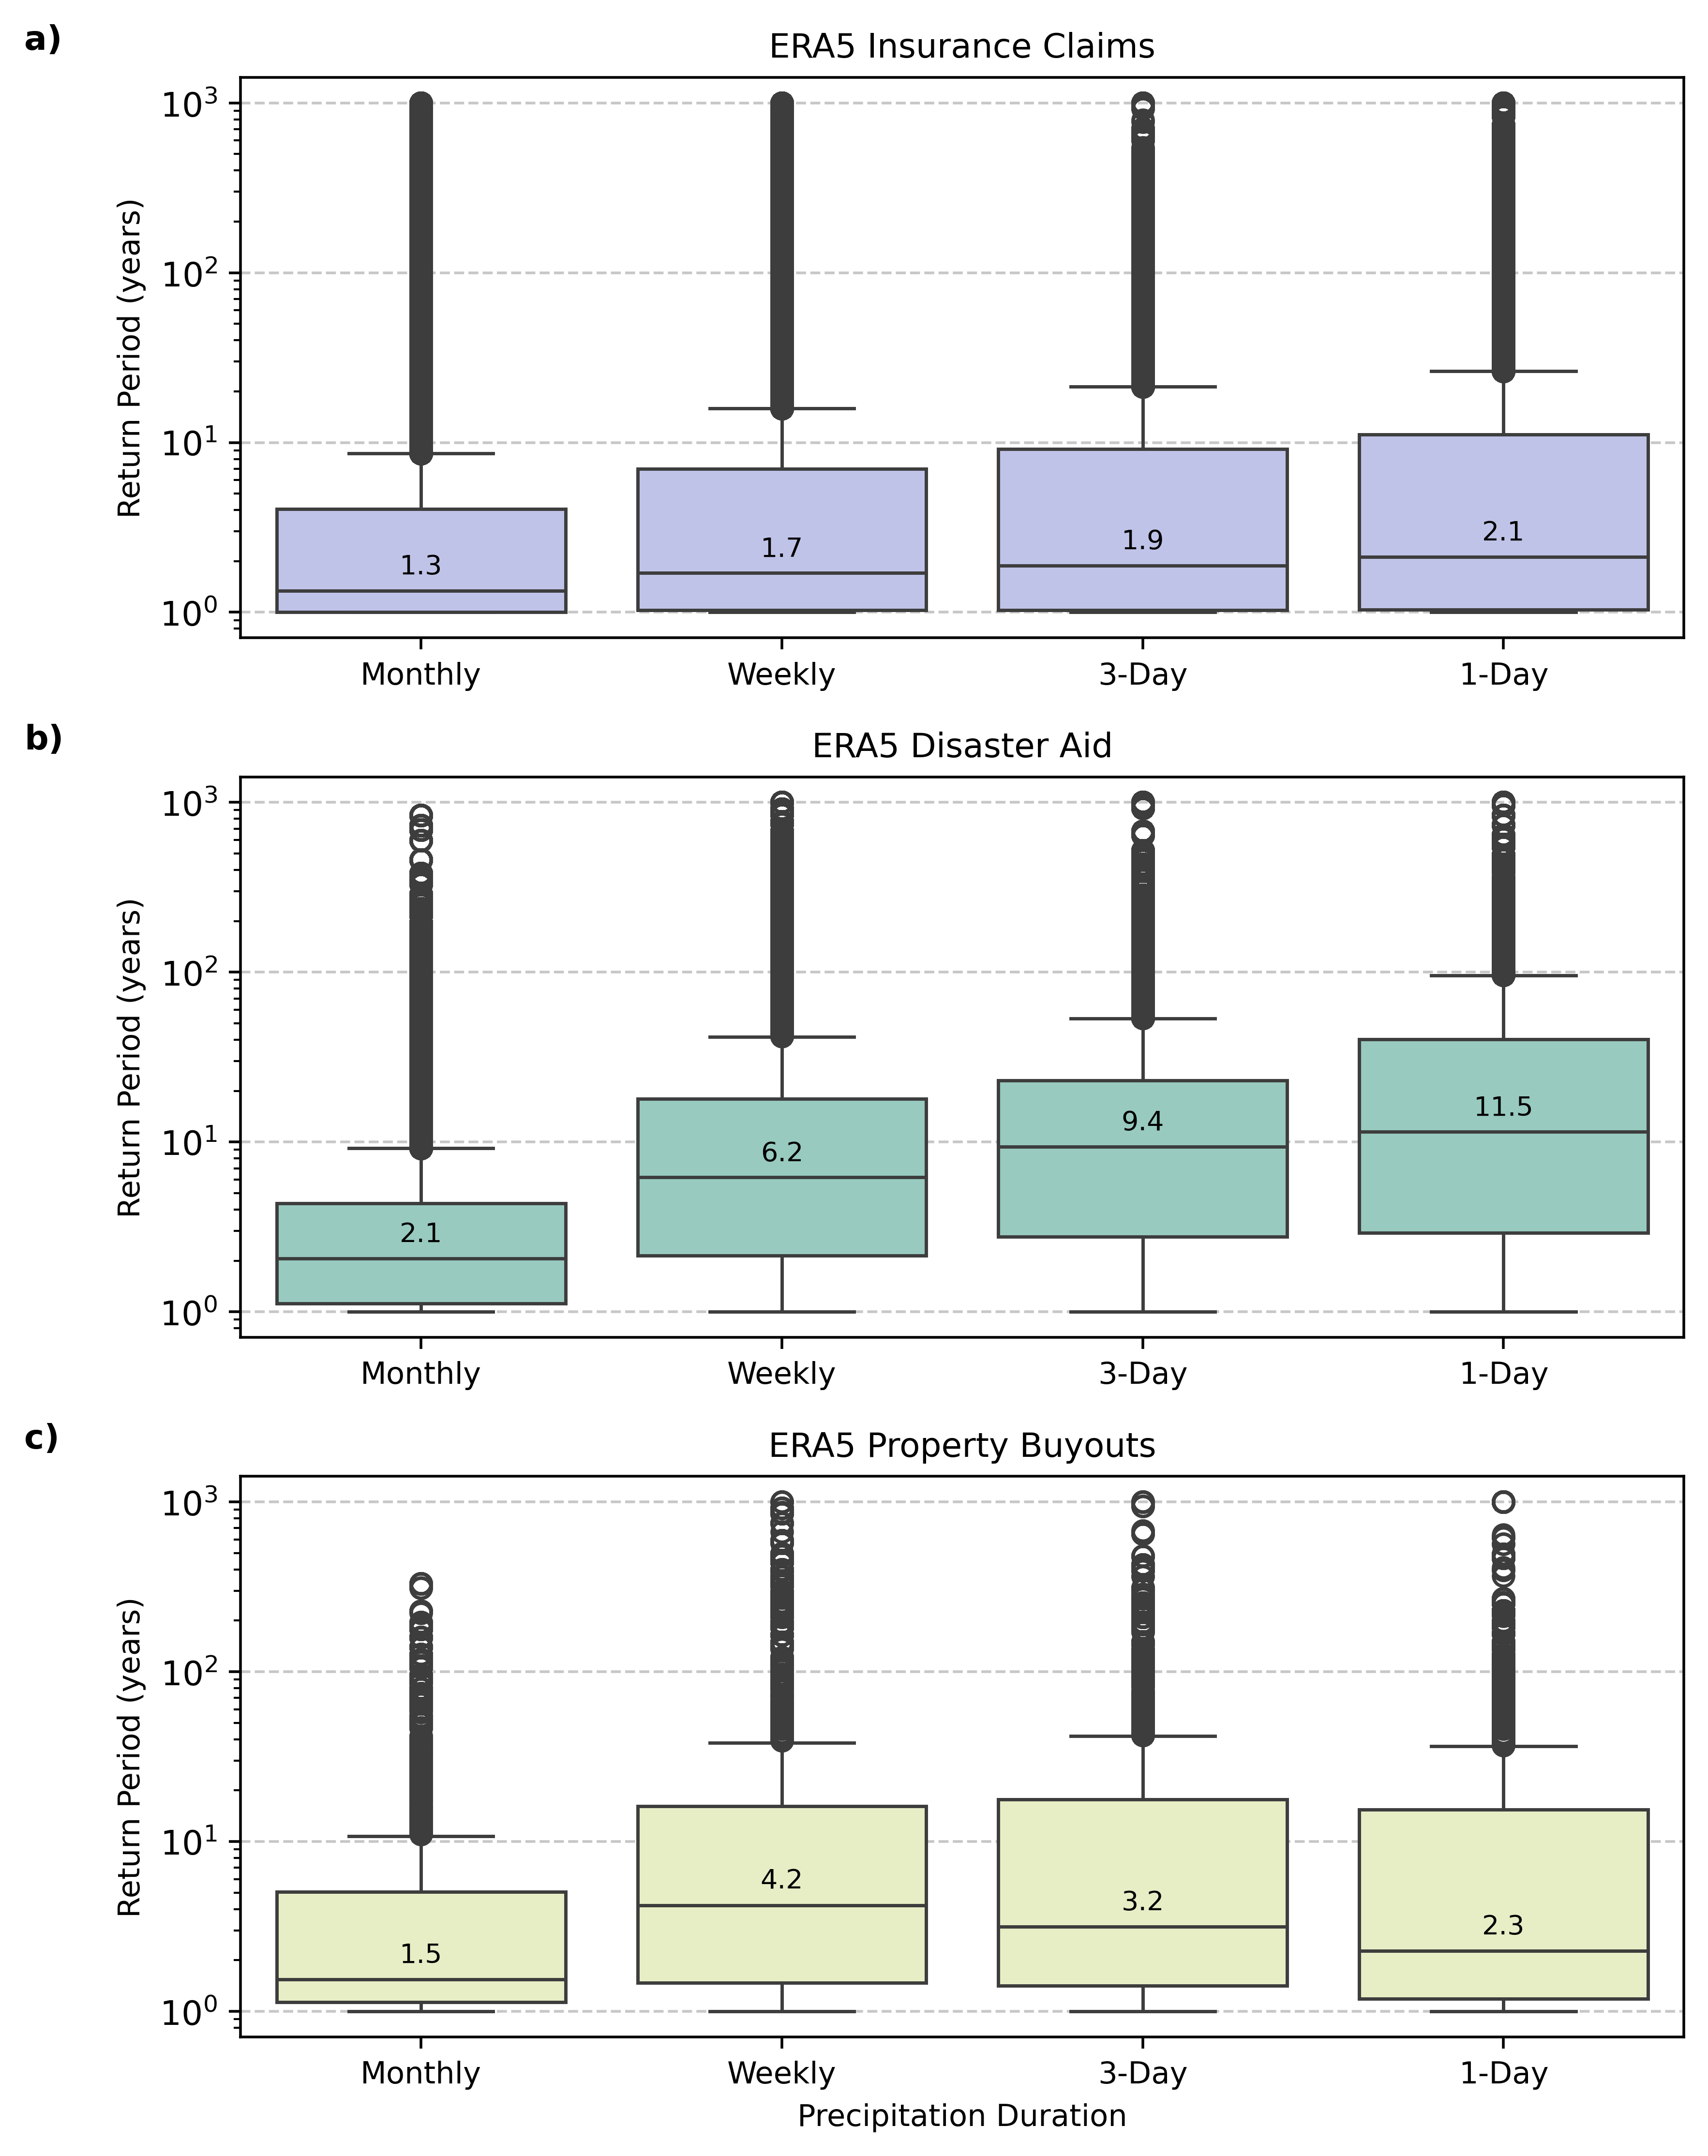

In [14]:
# Set figure size with a width constraint of 7.09 inches (~180mm)
fig_width = 7.09  # inches
fig_height = 9    # Adjust height for three rows
fig, axes = plt.subplots(3, 1, figsize=(fig_width, fig_height), dpi=500)

# Titles for the subplots
titles = ['ERA5 Insurance Claims', 'ERA5 Disaster Aid', 'ERA5 Property Buyouts']

# Plotting the boxplots
sns.boxplot(data=data_era, ax=axes[0], showfliers=True, color="#babeee")
sns.boxplot(data=data_era_aid, ax=axes[1], showfliers=True, color="#90d2c3")
sns.boxplot(data=data_era_buyouts, ax=axes[2], showfliers=True, color="#ecf4be")

# Add median labels
label_medians(axes[0], data_era)
label_medians(axes[1], data_era_aid)
label_medians(axes[2], data_era_buyouts)

# Set subplot titles
for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks(range(len(data_labels)))
    ax.set_xticklabels(data_labels, fontsize=9)
    ax.set_yscale("log")
    ax.set_ylabel('Return Period (years)', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add a common xlabel for all plots
axes[2].set_xlabel('Precipitation Duration', fontsize=9)

# Add subplot labels
axes[0].text(-0.15, 1.05, 'a)', transform=axes[0].transAxes, size=10, weight='bold')
axes[1].text(-0.15, 1.05, 'b)', transform=axes[1].transAxes, size=10, weight='bold')
axes[2].text(-0.15, 1.05, 'c)', transform=axes[2].transAxes, size=10, weight='bold')

# Adjust layout and save the plot if needed
plt.tight_layout()
if save:
    plt.savefig('../../../Plots/SI/F2_ERA5.png', dpi=500)
plt.show()